# Model comparison 

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import warnings

# For better plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')
warnings.filterwarnings('ignore')

# Import the permutation weighting implementation
import sys
sys.path.append('.')  # Add the current directory to path
try:
    from permutation_weighting.estimator import PW
    print("Successfully imported PW from the package")
except ImportError:
    print("Failed to import PW from the package - will implement a simplified version")

# Kang-Schafer DGP for binary treatment
def generate_kang_schafer_binary(n=1000, seed=42, misspecified=False):
    """
    Generate data according to the Kang-Schafer setup with binary treatment
    
    Parameters:
    -----------
    n: int
        Number of observations
    seed: int
        Random seed
    misspecified: bool
        Whether to return the misspecified transformations of covariates
        
    Returns:
    --------
    df: pd.DataFrame
        Data frame with columns: X1-X4 (covariates), A (treatment), Y (outcome), 
        Y1 (potential outcome under treatment), Y0 (potential outcome under control),
        and X1_mis to X4_mis (misspecified covariates, if requested)
    """
    np.random.seed(seed)
    
    # Generate covariates
    X = np.random.normal(0, 1, size=(n, 4))
    
    # Treatment assignment
    ps_linear = X[:, 0] - 0.5 * X[:, 1] + 0.25 * X[:, 2] + 0.1 * X[:, 3]
    ps = expit(ps_linear)
    A = np.random.binomial(1, ps, size=n)
    
    # Generate potential outcomes
    Y1 = 210 + 1 + 27.4*X[:, 0] + 13.7*X[:, 1] + 13.7*X[:, 2] + 13.7*X[:, 3] + np.random.normal(0, 1, size=n)
    Y0 = 210 + 0 + 27.4*X[:, 0] + 13.7*X[:, 1] + 13.7*X[:, 2] + 13.7*X[:, 3] + np.random.normal(0, 1, size=n)
    
    # Observed outcome
    Y = A * Y1 + (1 - A) * Y0
    
    # Create DataFrame
    df = pd.DataFrame({
        'X1': X[:, 0],
        'X2': X[:, 1],
        'X3': X[:, 2],
        'X4': X[:, 3],
        'A': A,
        'Y': Y,
        'Y1': Y1,
        'Y0': Y0
    })
    
    # Add misspecified covariates if requested
    if misspecified:
        df['X1_mis'] = np.exp(X[:, 0]/2)
        df['X2_mis'] = X[:, 1] / (1 + np.exp(X[:, 0])) + 10
        df['X3_mis'] = (X[:, 0] * X[:, 2] / 25 + 0.6)**3
        df['X4_mis'] = (X[:, 1] + X[:, 3] + 20)**2
    
    return df


Successfully imported PW from the package


In [19]:
# Now I'll implement simplified versions of the baseline methods for comparison
# 1. Stabilized Inverse Propensity Score Weighting (IPSW)
def compute_ipsw_binary(A, X, misspecified=False):
    """
    Compute Stabilized Inverse Propensity Score Weights for binary treatment
    
    Parameters:
    -----------
    A: array-like
        Binary treatment indicator
    X: array-like or DataFrame
        Covariates
    misspecified: bool
        Whether to use misspecified covariates (X*_mis) if available
        
    Returns:
    --------
    weights: array
        Stabilized IPW weights
    """
    if isinstance(X, pd.DataFrame):
        if misspecified and 'X1_mis' in X.columns:
            X_mat = X[['X1_mis', 'X2_mis', 'X3_mis', 'X4_mis']].values
        else:
            X_mat = X[['X1', 'X2', 'X3', 'X4']].values
    else:
        X_mat = X
    
    # Fit propensity score model
    ps_model = LogisticRegression(max_iter=1000)
    ps_model.fit(X_mat, A)
    
    # Compute propensity scores
    ps = ps_model.predict_proba(X_mat)[:, 1]
    
    # Marginal treatment probability
    p_A = np.mean(A)
    
    # Compute stabilized weights
    weights = np.where(A == 1, p_A / ps, (1 - p_A) / (1 - ps))
    
    return weights


In [20]:

# Basic implementation of CBPS (simplified version)
from sklearn.linear_model import LogisticRegression

def compute_cbps_binary(A, X, misspecified=False):
    """
    Simplified version of Covariate Balancing Propensity Score for binary treatment
    
    Parameters:
    -----------
    A: array-like
        Binary treatment indicator
    X: array-like or DataFrame
        Covariates
    misspecified: bool
        Whether to use misspecified covariates (X*_mis) if available
        
    Returns:
    --------
    weights: array
        CBPS weights
    """
    if isinstance(X, pd.DataFrame):
        if misspecified and 'X1_mis' in X.columns:
            X_mat = X[['X1_mis', 'X2_mis', 'X3_mis', 'X4_mis']].values
        else:
            X_mat = X[['X1', 'X2', 'X3', 'X4']].values
    else:
        X_mat = X
    
    # This is a simplification - true CBPS adds balance constraints
    # For demonstration, we'll just use logistic regression with L2 penalty
    ps_model = LogisticRegression(C=0.1, max_iter=1000)
    ps_model.fit(X_mat, A)
    
    # Compute propensity scores
    ps = ps_model.predict_proba(X_mat)[:, 1]
    
    # Marginal treatment probability
    p_A = np.mean(A)
    
    # Compute weights
    weights = np.where(A == 1, p_A / ps, (1 - p_A) / (1 - ps))
    
    return weights

In [21]:
def compute_ipsw_gbm(A, X, misspecified=False):
    """
    Compute IPSW weights using gradient boosting
    
    Parameters:
    -----------
    A: array-like
        Treatment indicator
    X: array-like or DataFrame
        Covariates
    misspecified: bool
        Whether to use misspecified covariates
        
    Returns:
    --------
    weights: array
        IPSW weights
    """
    if isinstance(X, pd.DataFrame):
        if misspecified and 'X1_mis' in X.columns:
            X_mat = X[['X1_mis', 'X2_mis', 'X3_mis', 'X4_mis']].values
        else:
            X_mat = X[['X1', 'X2', 'X3', 'X4']].values
    else:
        X_mat = X
    
    # Fit propensity score model with GBM
    gbm = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1)
    gbm.fit(X_mat, A)
    
    # Compute propensity scores
    ps = gbm.predict_proba(X_mat)[:, 1]
    
    # Clip propensity scores to avoid extreme weights
    ps = np.clip(ps, 0.01, 0.99)
    
    # Marginal treatment probability
    p_A = np.mean(A)
    
    # Compute stabilized weights
    weights = np.where(A == 1, p_A / ps, (1 - p_A) / (1 - ps))
    
    return weights

In [22]:
def compute_sbw_binary(A, X, misspecified=False):
    """
    Simplified version of Stabilized Balancing Weights for binary treatment
    
    Parameters:
    -----------
    A: array-like
        Binary treatment indicator
    X: array-like or DataFrame
        Covariates
    misspecified: bool
        Whether to use misspecified covariates
        
    Returns:
    --------
    weights: array
        SBW weights
    """
    import cvxpy as cp # TODO: add cvxpy to requirements iff used in the package
    
    if isinstance(X, pd.DataFrame):
        if misspecified and 'X1_mis' in X.columns:
            X_mat = X[['X1_mis', 'X2_mis', 'X3_mis', 'X4_mis']].values
        else:
            X_mat = X[['X1', 'X2', 'X3', 'X4']].values
    else:
        X_mat = X
    
    n = len(A)
    n_treated = np.sum(A)
    n_control = n - n_treated
    
    # Separate covariates for treated and control
    X_treated = X_mat[A == 1]
    X_control = X_mat[A == 0]
    
    # Calculate means
    treated_mean = np.mean(X_treated, axis=0)
    
    # Initialize weights for control units
    w = cp.Variable(n_control, nonneg=True)
    
    # Balance constraint: weighted mean of control features equals mean of treated features
    balance_constraint = []
    for j in range(X_mat.shape[1]):
        # Allow small imbalance (delta)
        delta = 0.1 * np.std(X_mat[:, j])
        balance_constraint.append(cp.abs(cp.sum(cp.multiply(w, X_control[:, j])) - treated_mean[j] * cp.sum(w)) <= delta)
    
    # Sum constraint
    balance_constraint.append(cp.sum(w) == 1)
    
    # Objective: minimize variance
    objective = cp.Minimize(cp.sum_squares(w - 1/n_control))
    
    # Solve optimization problem
    prob = cp.Problem(objective, balance_constraint)
    try:
        prob.solve(solver=cp.OSQP)
    except:
        try:
            prob.solve(solver=cp.ECOS)
        except:
            prob.solve(solver=cp.SCS)
    
    # Create final weights vector
    weights = np.ones(n)
    weights[A == 0] = w.value * n_control
    
    return weights

# EVALUATE 

In [23]:
def evaluate_ate_binary(df, weights, true_ate=1.0):
    """
    Evaluate ATE estimation for binary treatment
    
    Parameters:
    -----------
    df: DataFrame
        Data with 'A', 'Y', 'Y1', 'Y0' columns
    weights: array-like
        Weights for each observation
    true_ate: float
        True average treatment effect
        
    Returns:
    --------
    dict
        Dictionary with bias and rmse
    """
    # Calculate weighted ATE
    treated_idx = df['A'] == 1
    control_idx = df['A'] == 0
    
    treated_mean = np.sum(df.loc[treated_idx, 'Y'] * weights[treated_idx]) / np.sum(weights[treated_idx])
    control_mean = np.sum(df.loc[control_idx, 'Y'] * weights[control_idx]) / np.sum(weights[control_idx])
    
    estimated_ate = treated_mean - control_mean
    
    error = estimated_ate - true_ate
    
    return error

def evaluate_dose_response_continuous(df, weights, treatment_grid=None):
    """
    Evaluate dose-response estimation for continuous treatment
    
    Parameters:
    -----------
    df: DataFrame
        Data with 'A', 'Y', 'true_dr' columns
    weights: array-like
        Weights for each observation
    treatment_grid: array-like, optional
        Grid of treatment values for evaluation
        
    Returns:
    --------
    dict
        Dictionary with integrated bias and rmse
    """
    from sklearn.linear_model import LinearRegression
    
    # Define treatment grid if not provided
    if treatment_grid is None:
        min_a, max_a = np.percentile(df['A'], [5, 95])
        treatment_grid = np.linspace(min_a, max_a, 50)
    
    # True dose-response function
    true_dr = [210 + 1/(1 + np.exp(a)) for a in treatment_grid]
    
    # Estimate dose-response function using weighted local linear regression
    est_dr = []
    for a in treatment_grid:
        # Calculate kernel weights
        bandwidth = (np.percentile(df['A'], 75) - np.percentile(df['A'], 25)) / 1.34
        kernel_weights = np.exp(-0.5 * ((df['A'] - a) / bandwidth)**2) * weights
        
        # Fit weighted linear regression
        model = LinearRegression()
        model.fit(
            df[['A']], 
            df['Y'],
            sample_weight=kernel_weights
        )
        
        # Predict at treatment value a
        est_dr.append(model.predict([[a]])[0])
    
    # Calculate integrated bias and RMSE
    bias = np.mean(np.abs(np.array(est_dr) - np.array(true_dr)))
    rmse = np.sqrt(np.mean((np.array(est_dr) - np.array(true_dr))**2))
    
    return {
        'integrated_bias': bias,
        'integrated_rmse': rmse,
        'treatment_grid': treatment_grid,
        'estimated_dr': est_dr,
        'true_dr': true_dr
    }

# SIMULATION BINARY

In [34]:
def run_binary_simulation(n_replications=100, sample_sizes=[500, 1000, 1500, 2000], 
                         misspecified=False, nn_configs=None):
    """
    Run simulation for binary treatment methods
    
    Parameters:
    -----------
    n_replications: int
        Number of simulation replications
    sample_sizes: list
        List of sample sizes to test
    misspecified: bool
        Whether to use misspecified covariates
    nn_configs: dict, optional
        Neural network configurations
        
    Returns:
    --------
    results: dict
        Dictionary with results for all methods
    """
    # Define baseline methods
    methods = {
        'Unweighted': lambda a, x: np.ones(len(a)),
        'IPSW-GLM': lambda a, x: compute_ipsw_binary(a, x, misspecified),
        'IPSW-GBM': lambda a, x: compute_ipsw_gbm(a, x, misspecified),
        'CBPS': lambda a, x: compute_cbps_binary(a, x, misspecified),
        'SBW': lambda a, x: compute_sbw_binary(a, x, misspecified)
    }
    
    
    # Standard trainers
    methods['PW-GLM'] = lambda a, x: PW(
        a, x, 
        classifier='logit', 
        estimand='ATE',
        num_replicates=50,
        estimand_params={'bootstrap': True}
    )['weights']
    
    methods['PW-Boosting'] = lambda a, x: PW(
        a, x, 
        classifier='boosting', 
        estimand='ATE',
        classifier_params={'n_estimators': 100, 'max_depth': 3},
        num_replicates=50,
        estimand_params={'bootstrap': True}
    )['weights']
    
    # SGD-based trainers if nn_configs is provided
    if nn_configs is not None:
        # SGD logistic regression
        methods['PW-SGD-Logit'] = lambda a, x: PW(
            a, x, 
            classifier='logit', 
            estimand='ATE',
            use_sgd=True,
            classifier_params={
                'alpha': nn_configs.get('alpha', 0.0001),
                'max_iter': nn_configs.get('epochs', 100),
                'learning_rate': 'optimal'
            },
            num_replicates=50,
            estimand_params={'bootstrap': True}
        )['weights']
        
        # Neural network
        methods['PW-Neural'] = lambda a, x: PW(
            a, x, 
            classifier='neural_net', 
            estimand='ATE',
            use_sgd=True,
            classifier_params={
                'hidden_layer_sizes': (nn_configs.get('hidden_size', 64),),
                'max_iter': nn_configs.get('epochs', 100),
                'batch_size': nn_configs.get('batch_size', 32),
                'learning_rate_init': nn_configs.get('learning_rate', 0.001)
            },
            num_replicates=50,
            estimand_params={'bootstrap': True}
        )['weights']
        
        # PyTorch-based trainers if available
        try:
            # Test if torch module exists
            import torch
            
            # MLP with PyTorch
            methods['PW-Torch-MLP'] = lambda a, x: PW(
                a, x, 
                classifier='mlp', 
                estimand='ATE',
                use_torch=True,
                classifier_params={
                    'hidden_dims': [nn_configs.get('hidden_size', 64), nn_configs.get('hidden_size', 64)//2],
                    'epochs': nn_configs.get('epochs', 100),
                    'batch_size': nn_configs.get('batch_size', 32),
                    'learning_rate': nn_configs.get('learning_rate', 0.001)
                },
                num_replicates=50,
                estimand_params={'bootstrap': True}
            )['weights']
            
        except ImportError:
            print("PyTorch not available, skipping PyTorch models")
    
    results = {
        method: {
            'bias': {size: [] for size in sample_sizes},
            'rmse': {size: [] for size in sample_sizes}
        } for method in methods
    }
    
    for rep in range(n_replications):
        for size in sample_sizes:
            print(f"Replication {rep+1}/{n_replications}, Sample size {size}")
            
            # Generate data
            df = generate_kang_schafer_binary(n=size, seed=rep, misspecified=misspecified)
            
            # Apply each method
            for method_name, method_func in methods.items():
                try:
                    x_features = df[['X1_mis', 'X2_mis', 'X3_mis', 'X4_mis']] if misspecified else df[['X1', 'X2', 'X3', 'X4']]
                    weights = method_func(df['A'].values, x_features)
                    
                    # Evaluate
                    eval_result = evaluate_ate_binary(df, weights)
                    
                    results[method_name]['bias'][size].append(eval_result['bias'])
                    results[method_name]['rmse'][size].append(eval_result['rmse'])
                except Exception as e:
                    print(f"Error with method {method_name}: {e}")
    
    # Compute mean and std
    summary = {
        method: {
            'mean_bias': {size: np.abs(np.mean(results[method]['error'][size])) for size in sample_sizes},
            'mean_mse': {size: np.mean(np.power(results[method]['error'][size], 2)) for size in sample_sizes},
            'std_bias': {size: np.std(results[method]['bias'][size]) for size in sample_sizes}, # TODO
            'std_rmse': {size: np.std(np.power(results[method]['error'][size], 2)) / np.sqrt(n_replications) for size in sample_sizes}
        } for method in methods
    }
    
    return results, summary



# CONTIOUS  TREAMTMENT

## Data generation for continuous treatment

In [44]:
# Kang-Schafer DGP for continuous treatment
def generate_kang_schafer_continuous(n=1000, seed=42, misspecified=False):
    """
    Generate data according to the Kang-Schafer setup with continuous treatment
    
    Parameters:
    -----------
    n: int
        Number of observations
    seed: int
        Random seed
    misspecified: bool
        Whether to return the misspecified transformations of covariates
        
    Returns:
    --------
    df: pd.DataFrame
        Data frame with columns: X1-X4 (covariates), A (treatment), Y (outcome),
        and X1_mis to X4_mis (misspecified covariates, if requested)
    """
    np.random.seed(seed)
    
    # Generate covariates
    X = np.random.normal(0, 1, size=(n, 4))
    
    # Treatment assignment (linear with noise)
    A_linear = X[:, 0] - 0.5 * X[:, 1] + 0.25 * X[:, 2] + 0.1 * X[:, 3]
    A = A_linear + np.random.normal(0, 1, size=n)
    
    # Generate outcome with non-linear treatment effect
    Y = 210 + 1/(1 + np.exp(A)) + 27.4*X[:, 0] + 13.7*X[:, 1] + 13.7*X[:, 2] + 13.7*X[:, 3] + np.random.normal(0, 1, size=n)
    
    # Create DataFrame
    df = pd.DataFrame({
        'X1': X[:, 0],
        'X2': X[:, 1],
        'X3': X[:, 2],
        'X4': X[:, 3],
        'A': A,
        'Y': Y
    })
    
    # True dose-response function (for evaluation)
    def true_dose_response(a):
        return 210 + 1/(1 + np.exp(a)) + 27.4 * 0 + 13.7 * 0 + 13.7 * 0 + 13.7 * 0  # Expectation of X is 0
    
    df['true_dr'] = [true_dose_response(a) for a in A]
    
    # Add misspecified covariates if requested
    if misspecified:
        df['X1_mis'] = np.exp(X[:, 0]/2)
        df['X2_mis'] = X[:, 1] / (1 + np.exp(X[:, 0])) + 10
        df['X3_mis'] = (X[:, 0] * X[:, 2] / 25 + 0.6)**3
        df['X4_mis'] = (X[:, 1] + X[:, 3] + 20)**2
    
    return df


# Check if our data generation works
# binary_df = generate_kang_schafer_binary(n=1000, seed=42, misspecified=True)
# print("Binary treatment data (first 5 rows):")
# print(binary_df.iloc[:5, :10])  # Show first 5 rows and 10 columns
# 
# continuous_df = generate_kang_schafer_continuous(n=1000, seed=42, misspecified=True)
# print("\nContinuous treatment data (first 5 rows):")
# print(continuous_df.iloc[:5, :10])  # Show first 5 rows and 10 columns

# other methods for continuous treatment

In [45]:
def compute_normal_linear_weights(A, X, misspecified=False):
    """
    Compute weights for continuous treatments using a normal-linear model
    
    Parameters:
    -----------
    A: array-like
        Continuous treatment variable
    X: array-like or DataFrame
        Covariates
    misspecified: bool
        Whether to use misspecified covariates
        
    Returns:
    --------
    weights: array
        Stabilized weights
    """
    from sklearn.linear_model import LinearRegression
    from scipy.stats import norm
    
    if isinstance(X, pd.DataFrame):
        if misspecified and 'X1_mis' in X.columns:
            X_mat = X[['X1_mis', 'X2_mis', 'X3_mis', 'X4_mis']].values
        else:
            X_mat = X[['X1', 'X2', 'X3', 'X4']].values
    else:
        X_mat = X
    
    # Fit linear regression for treatment given covariates
    model = LinearRegression()
    model.fit(X_mat, A)
    
    # Predict treatment and calculate residuals
    A_pred = model.predict(X_mat)
    resid = A - A_pred
    
    # Estimate residual variance
    sigma = np.std(resid)
    
    # Compute likelihood of observed treatment under model
    pdf_cond = norm.pdf(A, loc=A_pred, scale=sigma)
    
    # Compute likelihood under marginal distribution
    pdf_marg = norm.pdf(A, loc=np.mean(A), scale=np.std(A))
    
    # Compute stabilized weights
    weights = pdf_marg / pdf_cond
    
    # Clip extreme weights
    weights = np.clip(weights, 0.01, 100)
    
    return weights

def compute_np_cbps(A, X, misspecified=False):
    """
    Compute non-parametric Covariate Balancing Propensity Score weights for continuous treatments
    
    Parameters:
    -----------
    A: array-like
        Continuous treatment variable
    X: array-like or DataFrame
        Covariates
    misspecified: bool
        Whether to use misspecified covariates
        
    Returns:
    --------
    weights: array
        CBPS weights
    """
    from sklearn.linear_model import LassoCV
    from sklearn.preprocessing import PolynomialFeatures
    
    if isinstance(X, pd.DataFrame):
        if misspecified and 'X1_mis' in X.columns:
            X_mat = X[['X1_mis', 'X2_mis', 'X3_mis', 'X4_mis']].values
        else:
            X_mat = X[['X1', 'X2', 'X3', 'X4']].values
    else:
        X_mat = X
    
    # Create polynomial features to approximate non-parametric model
    poly = PolynomialFeatures(degree=2, include_bias=True)
    X_poly = poly.fit_transform(X_mat)
    
    # Fit Lasso model with cross-validation for regularization
    model = LassoCV(cv=5, max_iter=2000, random_state=42)
    model.fit(X_poly, A)
    
    # Compute residuals
    A_pred = model.predict(X_poly)
    resid = A - A_pred
    
    # Estimate density ratio using balancing constraint approach
    # This is a simplified approximation to npCBPS
    
    # Compute covariance between residuals and covariate functions
    cov_mat = np.zeros((X_poly.shape[1], 1))
    for j in range(X_poly.shape[1]):
        cov_mat[j, 0] = np.cov(X_poly[:, j], resid)[0, 1]
    
    # Compute weights using exponential tilting
    lambda_param = np.linalg.solve(np.cov(X_poly, rowvar=False) + 0.001 * np.eye(X_poly.shape[1]), cov_mat)
    scores = X_poly @ lambda_param
    
    # Apply exponential tilting and normalize
    weights = np.exp(scores - np.mean(scores))
    weights = weights / np.mean(weights) * len(A)
    
    # Clip extreme weights
    weights = np.clip(weights, 0.01, 100)
    
    return weights

# continuous treatment simulation

In [41]:
def run_continuous_simulation(n_replications=100, sample_sizes=[500, 1000, 1500, 2000], 
                             misspecified=False, nn_configs=None):
    """
    Run simulation for continuous treatment methods
    
    Parameters:
    -----------
    n_replications: int
        Number of simulation replications
    sample_sizes: list
        List of sample sizes to test
    misspecified: bool
        Whether to use misspecified covariates
    nn_configs: dict, optional
        Neural network configurations
        
    Returns:
    --------
    results: dict
        Dictionary with results for all methods
    """
    # Define baseline methods
    methods = {
        'Unweighted': lambda a, x: np.ones(len(a)),
    }
    
    # Add normal linear model for continuous treatments
    methods['Normal-Linear'] = lambda a, x: compute_normal_linear_weights(a, x, misspecified)
    
    # Add non-parametric CBPS for continuous treatments
    methods['npCBPS'] = lambda a, x: compute_np_cbps(a, x, misspecified)
    
    
    # Standard trainers
    methods['PW-GLM'] = lambda a, x: PW(
        a, x, 
        classifier='logit', 
        estimand='ATE',
        num_replicates=50,
        estimand_params={'bootstrap': True}
    )['weights']
    
    methods['PW-Boosting'] = lambda a, x: PW(
        a, x, 
        classifier='boosting', 
        estimand='ATE',
        classifier_params={'n_estimators': 100, 'max_depth': 3},
        num_replicates=50,
        estimand_params={'bootstrap': True}
    )['weights']
    
    # SGD-based trainers if nn_configs is provided
    if nn_configs is not None:
        # SGD logistic regression
        methods['PW-SGD-Logit'] = lambda a, x: PW(
            a, x, 
            classifier='logit', 
            estimand='ATE',
            use_sgd=True,
            classifier_params={
                'alpha': nn_configs.get('alpha', 0.0001),
                'max_iter': nn_configs.get('epochs', 100),
                'learning_rate': 'optimal'
            },
            num_replicates=50,
            estimand_params={'bootstrap': True}
        )['weights']
        
        # Neural network with minibatch training
        methods['PW-Neural'] = lambda a, x: PW(
            a, x, 
            classifier='neural_net', 
            estimand='ATE',
            use_sgd=True,
            batch_size=nn_configs.get('batch_size', 32),
            classifier_params={
                'hidden_layer_sizes': (nn_configs.get('hidden_size', 64),),
                'max_iter': nn_configs.get('epochs', 100),
                'batch_size': nn_configs.get('batch_size', 32),
                'learning_rate_init': nn_configs.get('learning_rate', 0.001)
            },
            num_replicates=50,
            estimand_params={'bootstrap': True}
        )['weights']
        
        # PyTorch-based trainers if available
        try:
            # Test if torch module exists
            import torch
            
            # MLP with PyTorch
            methods['PW-Torch-MLP'] = lambda a, x: PW(
                a, x, 
                classifier='mlp', 
                estimand='ATE',
                use_torch=True,
                classifier_params={
                    'hidden_dims': [nn_configs.get('hidden_size', 64), nn_configs.get('hidden_size', 64)//2],
                    'epochs': nn_configs.get('epochs', 100),
                    'batch_size': nn_configs.get('batch_size', 32),
                    'learning_rate': nn_configs.get('learning_rate', 0.001)
                },
                num_replicates=50,
                estimand_params={'bootstrap': True}
            )['weights']
            
            # ResNet-style model with PyTorch
            methods['PW-Torch-ResNet'] = lambda a, x: PW(
                a, x, 
                classifier='resnet', 
                estimand='ATE',
                use_torch=True,
                classifier_params={
                    'hidden_dim': nn_configs.get('hidden_size', 64),
                    'num_blocks': nn_configs.get('num_blocks', 2),
                    'epochs': nn_configs.get('epochs', 100),
                    'batch_size': nn_configs.get('batch_size', 32),
                    'learning_rate': nn_configs.get('learning_rate', 0.001)
                },
                num_replicates=50,
                estimand_params={'bootstrap': True}
            )['weights']
            
        except ImportError:
            print("PyTorch not available, skipping PyTorch models")
    
    results = {
        method: {
            'integrated_bias': {size: [] for size in sample_sizes},
            'integrated_rmse': {size: [] for size in sample_sizes}
        } for method in methods
    }
    
    for rep in range(n_replications):
        for size in sample_sizes:
            print(f"Replication {rep+1}/{n_replications}, Sample size {size}")
            
            # Generate data
            df = generate_kang_schafer_continuous(n=size, seed=rep, misspecified=misspecified)
            
            # Apply each method
            for method_name, method_func in methods.items():
                try:
                    x_features = df[['X1_mis', 'X2_mis', 'X3_mis', 'X4_mis']] if misspecified else df[['X1', 'X2', 'X3', 'X4']]
                    weights = method_func(df['A'].values, x_features)
                    
                    # Evaluate
                    eval_result = evaluate_dose_response_continuous(df, weights)
                    
                    results[method_name]['integrated_bias'][size].append(eval_result['integrated_bias'])
                    results[method_name]['integrated_rmse'][size].append(eval_result['integrated_rmse'])
                except Exception as e:
                    print(f"Error with method {method_name}: {e}")
    
    # Compute mean and std
    summary = {
        method: {
            'mean_integrated_bias': {size: np.mean(results[method]['integrated_bias'][size]) for size in sample_sizes},
            'mean_integrated_rmse': {size: np.mean(results[method]['integrated_rmse'][size]) for size in sample_sizes},
            'std_integrated_bias': {size: np.std(results[method]['integrated_bias'][size]) for size in sample_sizes},
            'std_integrated_rmse': {size: np.std(results[method]['integrated_rmse'][size]) for size in sample_sizes}
        } for method in methods
    }
    
    return results, summary

# VISUALIZATION

In [46]:
def plot_simulation_results(summary, metric_name, title):
    """
    Plot simulation results
    
    Parameters:
    -----------
    summary: dict
        Summary of simulation results
    metric_name: str
        Metric to plot (e.g., 'mean_bias', 'mean_rmse')
    title: str
        Plot title
    """
    plt.figure(figsize=(12, 8))
    
    methods = list(summary.keys())
    sample_sizes = list(summary[methods[0]][metric_name].keys())
    
    marker_styles = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    colors = plt.cm.tab10.colors
    
    for i, method in enumerate(methods):
        values = [summary[method][metric_name][size] for size in sample_sizes]
        std_values = [summary[method].get(f'std_{metric_name.replace("mean_", "")}', {}).get(size, 0) for size in sample_sizes]
        
        plt.errorbar(
            sample_sizes, values, yerr=std_values,
            marker=marker_styles[i % len(marker_styles)],
            color=colors[i % len(colors)],
            label=method,
            linewidth=2,
            markersize=8,
            capsize=5
        )
    
    plt.xscale('linear')
    plt.xlabel('Sample Size', fontsize=14)
    plt.ylabel(metric_name.replace('_', ' ').title(), fontsize=14)
    plt.title(title, fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    return plt.gcf()

def create_comparison_plots(binary_summary, continuous_summary):
    """
    Create comparison plots for binary and continuous simulations
    
    Parameters:
    -----------
    binary_summary: dict
        Summary for binary treatment simulation
    continuous_summary: dict
        Summary for continuous treatment simulation
    """
    # Create subplots for binary treatment
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Sample sizes
    sample_sizes = list(binary_summary[list(binary_summary.keys())[0]]['mean_bias'].keys())
    
    # Plot settings
    marker_styles = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    colors = plt.cm.tab10.colors
    
    # Plot binary treatment results
    for i, (method, results) in enumerate(binary_summary.items()):
        # Bias plot
        bias_values = [results['mean_bias'][size] for size in sample_sizes]
        axes[0].plot(sample_sizes, bias_values, 
                    marker=marker_styles[i % len(marker_styles)],
                    color=colors[i % len(colors)], 
                    label=method,
                    linewidth=2,
                    markersize=8)
        
        # RMSE plot
        rmse_values = [results['mean_rmse'][size] for size in sample_sizes]
        axes[1].plot(sample_sizes, rmse_values, 
                    marker=marker_styles[i % len(marker_styles)],
                    color=colors[i % len(colors)], 
                    label=method,
                    linewidth=2,
                    markersize=8)
    
    # Set titles and labels
    axes[0].set_title('Integrated Mean Absolute Bias', fontsize=16)
    axes[1].set_title('Integrated RMSE', fontsize=16)
    
    for ax in axes:
        ax.set_xlabel('Sample Size', fontsize=14)
        ax.set_ylabel('Metric Value', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=12)
    
    plt.tight_layout()
    fig.savefig('tuning_results/binary_treatment_results.png', dpi=300, bbox_inches='tight')
    
    # Create subplots for continuous treatment
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot continuous treatment results
    for i, (method, results) in enumerate(continuous_summary.items()):
        # Bias plot
        bias_values = [results['mean_integrated_bias'][size] for size in sample_sizes]
        axes[0].plot(sample_sizes, bias_values, 
                    marker=marker_styles[i % len(marker_styles)],
                    color=colors[i % len(colors)], 
                    label=method,
                    linewidth=2,
                    markersize=8)
        
        # RMSE plot
        rmse_values = [results['mean_integrated_rmse'][size] for size in sample_sizes]
        axes[1].plot(sample_sizes, rmse_values, 
                    marker=marker_styles[i % len(marker_styles)],
                    color=colors[i % len(colors)], 
                    label=method,
                    linewidth=2,
                    markersize=8)
    
    # Set titles and labels
    axes[0].set_title('Integrated Mean Absolute Bias', fontsize=16)
    axes[1].set_title('Integrated RMSE', fontsize=16)
    
    for ax in axes:
        ax.set_xlabel('Sample Size', fontsize=14)
        ax.set_ylabel('Metric Value', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=12)
    
    plt.tight_layout()
    fig.savefig('tuning_results/continuous_treatment_results.png', dpi=300, bbox_inches='tight')

# RUN FULL COMPARISSON 

Running binary treatment simulation (correctly specified)...
Replication 1/1, Sample size 200
Replication 1/1, Sample size 400
Replication 1/1, Sample size 700
Replication 1/1, Sample size 1000
Running binary treatment simulation (misspecified)...
Replication 1/1, Sample size 200
Replication 1/1, Sample size 400
Replication 1/1, Sample size 700
Replication 1/1, Sample size 1000
Running continuous treatment simulation (correctly specified)...
Replication 1/1, Sample size 200
Error with method npCBPS: Data must be 1-dimensional, got ndarray of shape (200, 200) instead
Replication 1/1, Sample size 400
Error with method npCBPS: Data must be 1-dimensional, got ndarray of shape (400, 400) instead
Replication 1/1, Sample size 700
Error with method npCBPS: Data must be 1-dimensional, got ndarray of shape (700, 700) instead
Replication 1/1, Sample size 1000
Error with method npCBPS: Data must be 1-dimensional, got ndarray of shape (1000, 1000) instead
Running continuous treatment simulation (mi

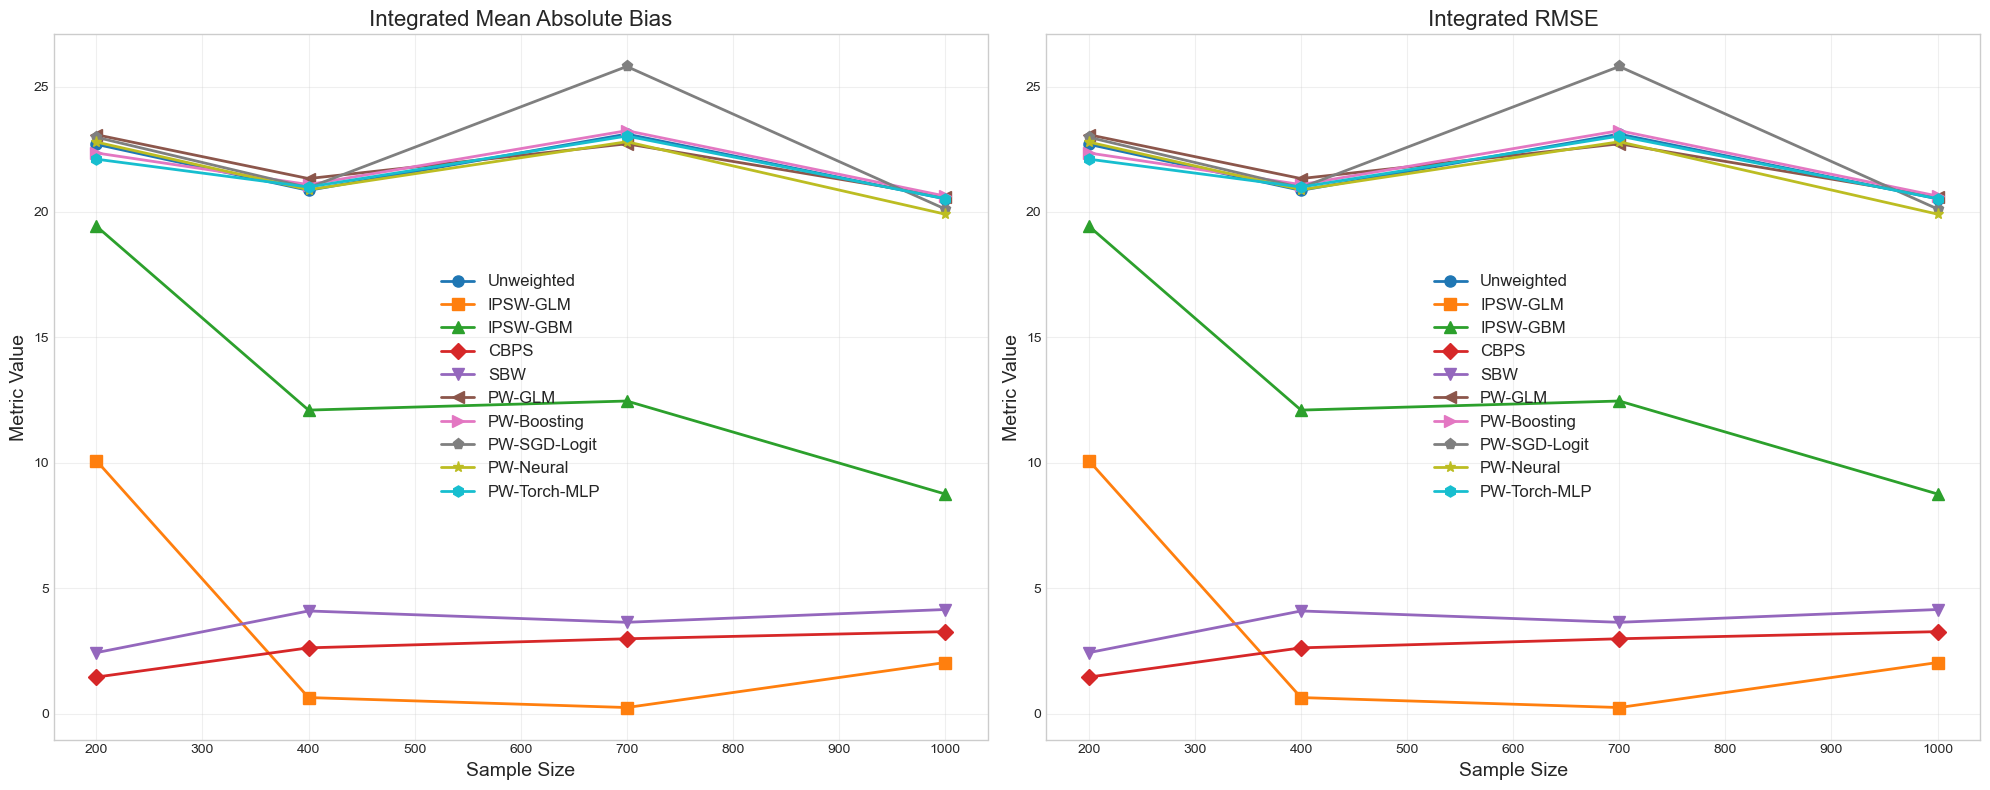

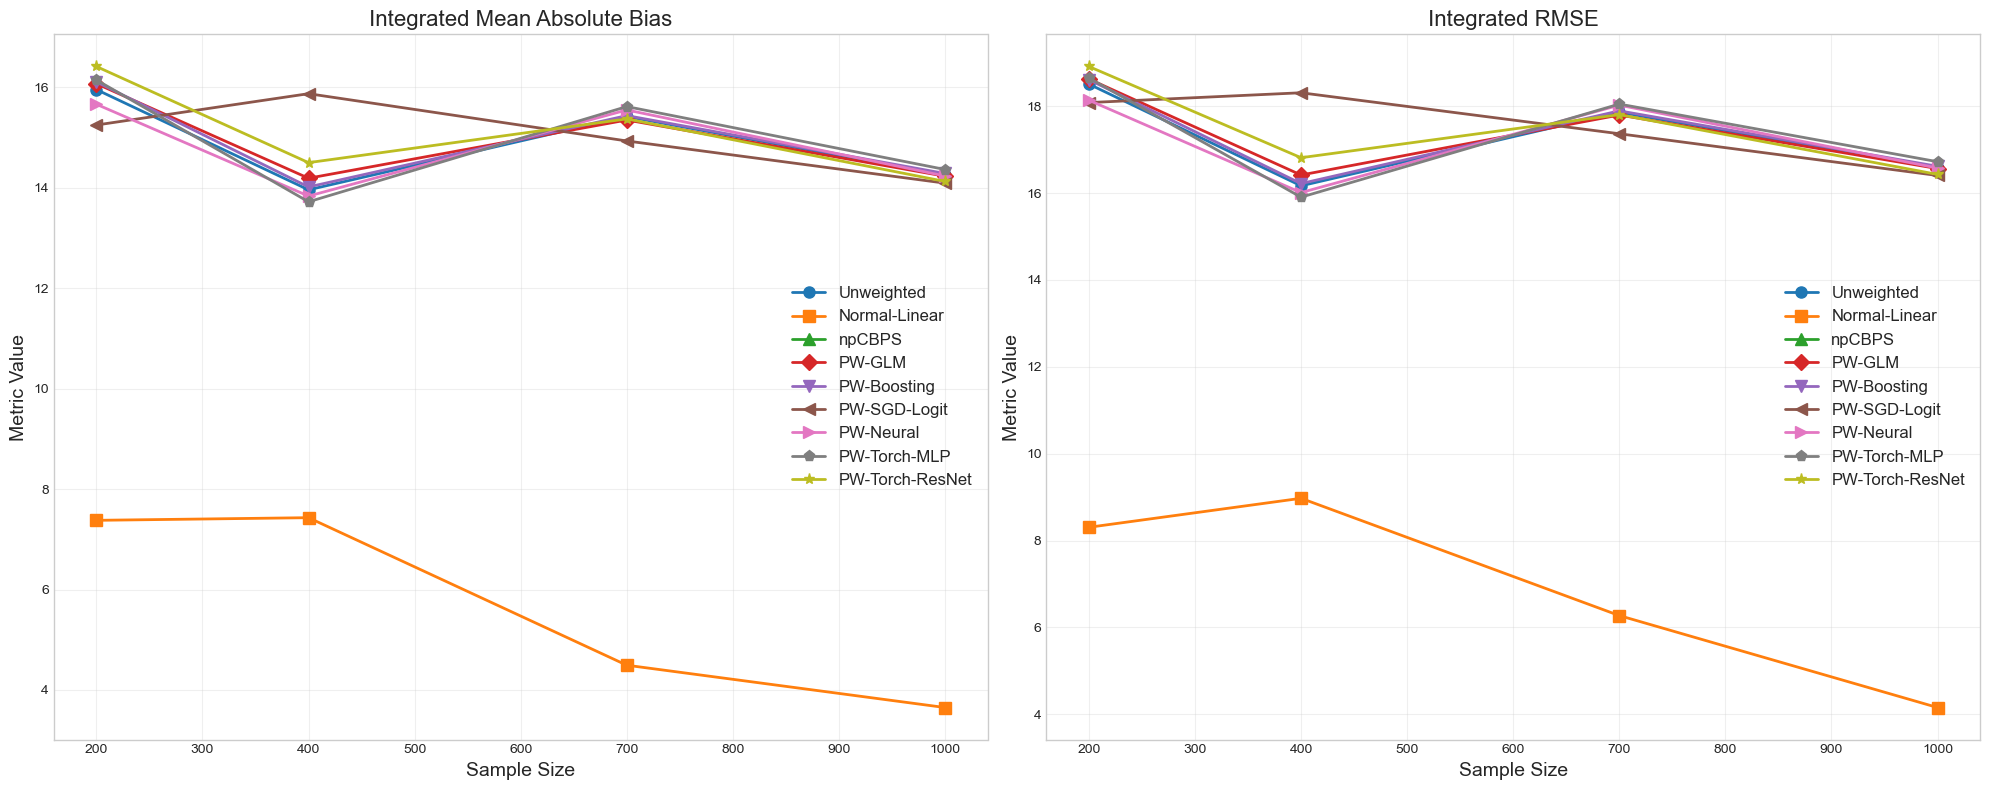

In [42]:
def main():
    """
    Main function to run simulations and create plots
    """
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Define sample sizes
    #sample_sizes = [500, 1000, 1500, 2000]
    sample_sizes = [200, 400, 700,1000]
    
    # Neural network configurations
    nn_configs = {
        'hidden_size': 64,
        'batch_size': 32,
        'epochs': 100
    }
    
    # Run binary treatment simulation with correctly specified covariates
    print("Running binary treatment simulation (correctly specified)...")
    binary_results, binary_summary = run_binary_simulation(
        n_replications=1,  # Reduce for testing, use 100 for final results
        sample_sizes=sample_sizes,
        misspecified=False,
        nn_configs=nn_configs
    )
    
    # Run binary treatment simulation with misspecified covariates
    print("Running binary treatment simulation (misspecified)...")
    binary_mis_results, binary_mis_summary = run_binary_simulation(
        n_replications=1,  # Reduce for testing, use 100 for final results
        sample_sizes=sample_sizes,
        misspecified=True,
        nn_configs=nn_configs
    )
    
    # Run continuous treatment simulation with correctly specified covariates
    print("Running continuous treatment simulation (correctly specified)...")
    continuous_results, continuous_summary = run_continuous_simulation(
        n_replications=1,  # Reduce for testing, use 100 for final results
        sample_sizes=sample_sizes,
        misspecified=False,
        nn_configs=nn_configs
    )
    
    # Run continuous treatment simulation with misspecified covariates
    print("Running continuous treatment simulation (misspecified)...")
    continuous_mis_results, continuous_mis_summary = run_continuous_simulation(
        n_replications=1,  # Reduce for testing, use 100 for final results
        sample_sizes=sample_sizes,
        misspecified=True,
        nn_configs=nn_configs
    )
    
    # Create plots
    print("Creating plots...")
    
    # Binary treatment, correctly specified
    create_comparison_plots(binary_summary, continuous_summary)
    
    # Save results
    print("Saving results...")
    import pickle
    with open('tuning_results/simulation_results.pkl', 'wb') as f:
        pickle.dump({
            'binary': {
                'results': binary_results,
                'summary': binary_summary,
                'misspecified_results': binary_mis_results,
                'misspecified_summary': binary_mis_summary
            },
            'continuous': {
                'results': continuous_results,
                'summary': continuous_summary,
                'misspecified_results': continuous_mis_results,
                'misspecified_summary': continuous_mis_summary
            }
        }, f)
    
    print("Done!")

if __name__ == "__main__":
    main()